In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import io
import requests

In [2]:
def OutPutData(url,input_data):
    s=requests.get(url).content
    df_temp = pandas.read_csv(io.StringIO(s.decode('utf-8')))

    df_temp = df_temp.sort('Date') 

    df_temp.to_csv('temp.csv', encoding='utf-8')
    # 載入資料
    #input_data = '3231-2010-2017'

    df = pandas.read_csv('temp.csv')


    #df['V'] =df["Volume"]/df["Volume"].rolling(window = 20, center = False).mean()
    df['V'] =df["Volume"]/1000000
    df['9dmax']=df["High"].rolling(window = 9, center = False).max()
    df['9dmin']=df["Low"].rolling(window = 9, center = False).min()
    df['RSV']=np.nan
    df['K'] = np.nan
    df['D'] = np.nan

    df['H20']=df["High"].rolling(window = 20, center = False).max()
    df['L20']=df["Low"].rolling(window = 20, center = False).min()
    df['H2K'] = np.nan
    df['L2K'] =np.nan
    df['20MA']=df["Close"].rolling(window = 20, center = False).mean()
    df['UB'] = np.nan
    df['LB'] =np.nan
    df['PB'] =np.nan
    df['P_1D'] =np.nan

    count = len(df.index)
    df.loc[7,'K'] = 50
    df.loc[7,'D'] = 50
    for i in range(0,count,1):
        #KD值計算
        if(i>7):
            df.loc[i,'RSV'] =   (df['Close'][i]-  df['9dmin'][i]) / (df['9dmax'][i] - df['9dmin'][i] ) *100
            df.loc[i,'K'] =   df['K'][i-1]*2/3 + df['RSV'][i]*1/3       
            df.loc[i,'D'] =   df['D'][i-1]*2/3 + df['K'][i]*1/3


        #布林通道計算
        #H-L 最高價-最低價
        theHmL = df['High'][i] - df['Low'][i]
        #(H+L)/2 (最高價+最低價) / 2
        theHpL = (df['High'][i] + df['Low'][i])/2
        #K=L/M 上兩個相除
        theK = theHmL/theHpL    
        #1+2K 1+兩倍的K值
        thep2K = 1+2*theK    
        #1-2K 1-兩倍的K值
        them2K = 1-2*theK
        #Hx(1+2K) 最高價*(1+兩倍的K值)
        df.loc[i,'H2K'] =thep2K * df['High'][i]
        #Lx(1-2K) 最低價*(1-兩倍的K值)
        df.loc[i,'L2K'] =them2K * df['Low'][i]  

        if(count != i+1):
            df.loc[i,'P_1D'] =df['Close'][i+1]

    df['UB'] = df["H2K"].rolling(window = 20, center = False).mean()
    df['LB'] = df["L2K"].rolling(window = 20, center = False).mean()
    df['PB']= (df['Close']-df['LB'])/(df['UB']-df['LB'])
    

    df_output = df.ix[19:count-2,['Date','High','Low','V','K','D','PB','Close','P_1D']]
    df_output.to_csv(input_data+'_output.csv', encoding='utf-8')

In [7]:
# 載入資料
Stock_id = '2454'
url_tt = 'http://real-chart.finance.yahoo.com/table.csv?s='+Stock_id+'.TW&d=2&e=31&f=2017&g=d&a=0&b=1&c=2012&ignore=.csv'
url_p = 'http://real-chart.finance.yahoo.com/table.csv?s='+Stock_id+'.TW&d=4&e=31&f=2017&g=d&a=0&b=1&c=2012&ignore=.csv'

OutPutData(url_tt,Stock_id)
OutPutData(url_p,Stock_id+'_p')

C:\Users\ahwei\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


# 深度學習

In [4]:
import numpy
import pandas
import math
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense,LSTM,Activation,Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from keras.layers.embeddings import Embedding
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 650 Ti BOOST (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)


In [8]:
def learning_model():
    model = Sequential()
    model.add(Dense(1500,input_dim = 6))
    model.add(Activation('relu'))
    model.add(Dropout(1))    
    model.add(Dense(500))    
    model.add(Activation('relu'))
    model.add(Dropout(1))
    model.add(Dense(1))
    model.add(Activation('linear'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

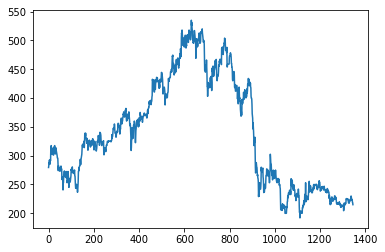

In [9]:
# load dataset
dataframe = pandas.read_csv(Stock_id+"_output.csv")
dataset = dataframe.values

plt.plot(dataset[:,9])
plt.show()

dataset = dataset[:,2:10]
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
trainX,trainY=dataset[:,0:6],dataset[:,7]



Epoch 1/10
2s - loss: 0.0035
Epoch 2/10
2s - loss: 0.0013
Epoch 3/10
2s - loss: 0.0011
Epoch 4/10
2s - loss: 0.0010
Epoch 5/10
2s - loss: 0.0011
Epoch 6/10
2s - loss: 8.3391e-04
Epoch 7/10
2s - loss: 8.2467e-04
Epoch 8/10
2s - loss: 7.9773e-04
Epoch 9/10
2s - loss: 7.4667e-04
Epoch 10/10
2s - loss: 7.8616e-04


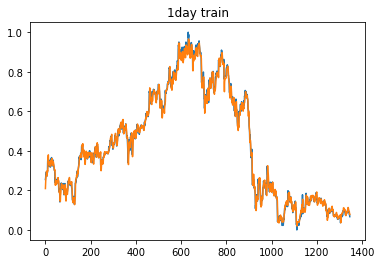

Train Score: 0.02 RMSE


In [10]:
#訓練開始
model =  learning_model()
model.fit(trainX, trainY, nb_epoch=10,batch_size=1, verbose=2,shuffle=True)

Predict_train = model.predict(trainX)
#Predict_test  = model.predict(testX)


#1day train
plt.title('1day train')
plt.plot(trainY)
plt.plot(Predict_train)
plt.show()


import math
from sklearn.metrics import mean_squared_error
#RMSE
trainScore = math.sqrt(mean_squared_error(trainY,Predict_train))
print('Train Score: %.2f RMSE' % (trainScore))

In [11]:
# load dataset
dataframe = pandas.read_csv(Stock_id+"_p_output.csv")
dataset = dataframe.values
dataset = dataset[:,2:10]
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [1]:
cal_money = dataframe.values
pre_list = []
#當預測會上漲時購買，直到上漲在買出否則繼續放著。
#會上漲就買10張
money = 0
cost=0
ROI = 0
for x in xrange(-30, 0,1):
    if(x==0):
        Predict_test  = model.predict(dataset[:,0:6])
    else:
        Predict_test  = model.predict(dataset[:x,0:6])
    #pre_list.append(Predict_test[-1]-Predict_test[-2])
    pre = Predict_test[-1]-Predict_test[-2]
    pre_2 =( Predict_test[-1]-Predict_test[-2])/Predict_test[-2]*100
    
   

    if(money == 0 and  pre>0):
        money =cal_money[x,8]*10000
        cost=cost+money        
    elif(cal_money[x,8]*10000 >money and money  != 0 ):
        ROI = ROI + cal_money[x,8]*10000
        money =0 
    
    
        
   
    
    
    print  cal_money[x,1], cal_money[x,8], cal_money[x,9],pre,ROI,cost,money
# pre_list
print 'ROI'
if(money>0):
     print (ROI-cost+(cal_money[-1,9])*10000)/cost*100
else:
    print (ROI-cost)/cost*100

NameError: name 'dataframe' is not defined

In [21]:
(5228000.0-5205000.0 ) /5205000.0 

0.004418828049951969

In [12]:
cal_money[-2,9]

198.0

In [143]:
cal_money = dataframe.values
cal_money[-1]

array([1388L, '2017-05-03', 101.5, 100.0, 42.603, 80.7379919128,
       73.8999290359, 1.0262420327700001, 100.5, 100.5], dtype=object)